# Deep Neural Network in NumPy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
import sklearn as sk
from sklearn import preprocessing

import abc

from IPython.display import Math
from IPython.display import Latex
import IPython.display as disp

import itertools as it
import copy

%matplotlib inline

## Activation functions

In [21]:
class Activation(metaclass=abc.ABCMeta):
    
    @abc.abstractmethod
    def function(self, x):
        """
        Implementation of the activation function.
        """
        
    @abc.abstractmethod
    def derivative(self, x):
        """
        Derivative of the activation function.
        """

#### _Sigmoid_

\begin{align}
f(x)=\frac{1}{1+e^{-x}}=\sigma(x)\quad
f'(x)=\sigma(x)\cdot(1-\sigma(x))=\frac{e^{-x}}{{(1+e^{-x}})^2}
\end{align}

In [3]:
class Sigmoid(Activation):
    
    def function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivative(self, x):
        return np.exp(-x)/((1+np.exp(-x))**2)

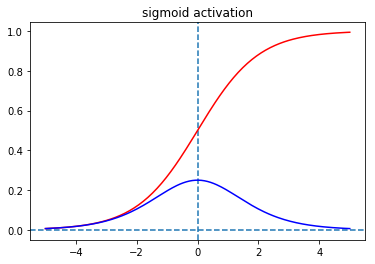

In [8]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("sigmoid activation")
plt.plot(x,Sigmoid().function(x), color="red")
plt.plot(x,Sigmoid().derivative(x), color="blue")

#### _ReLU_

\begin{align}
f(x)=\begin{cases}
  x, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}\quad
f'(x)=\begin{cases}
  1, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}
\end{align}

In [32]:
class Relu(Activation):
    
    def function(self, x):
        return x * (x > 0)

    def derivative(self, x):
        return np.array(x * (x > 0) != 0, dtype="int")

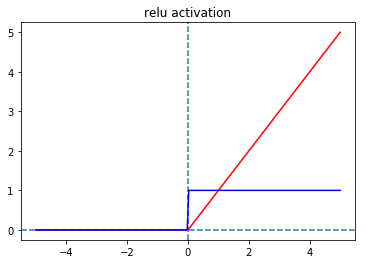

In [115]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("relu activation")
plt.plot(x,Relu().function(x), color="red")
plt.plot(x,Relu().derivative(x), color="blue")

#### _Softplus_

\begin{align}
f(x)=log(1 + e^x)
\quad
f'(x)=\frac{e^x}{1 + e^x}
\end{align}

In [7]:
class Softplus(Activation):
    # similar to relu but slower
    
    def function(self, x):
        return np.log(1 + np.exp(x))

    def derivative(self, x):
        return np.exp(x)/(1 + np.exp(x))

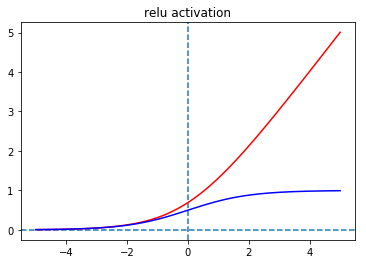

In [117]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("relu activation")
plt.plot(x,Softplus().function(x), color="red")
plt.plot(x,Softplus().derivative(x), color="blue")

#### _Hyperbolic Tangent_

\begin{align}
f(x)=\frac{e^{2x}-1}{e^{2x}+1}
\quad
f'(x)=\frac{4}{{e^{2x}+2+e^{-2x}}}
\end{align}

In [33]:
class Tanh(Activation):
    
    def function(self, x):
        return (np.exp(2*x) - 1)/(np.exp(2*x) + 1)

    def derivative(self, x):
        # hyperbolic secant to the power of 2
        return 4/(np.exp(2*x) + 2 + np.exp(-2*x))

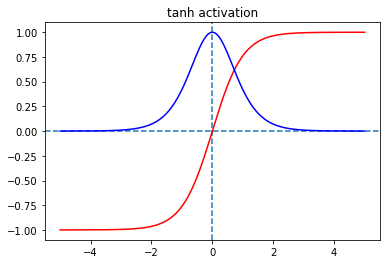

In [46]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("tanh activation")
plt.plot(x,Tanh().function(x), color="red")
plt.plot(x,Tanh().derivative(x), color="blue")

#### _Softmax_

\begin{align}
f(x_j)=\frac{e^{x_j}}{\sum_i^n{e^{x_i}}}
\quad
f'(x_j)=\begin{cases}
  f(x_j)\cdot (1-f(x_j)) &  j = k, \\
  -f(x_j)\cdot f(x_k) & j \not= k.
\end{cases}
\end{align}

In [16]:
class Softmax(Activation):
    
    def function(self, x):
        return np.exp(x)/(np.sum(np.exp(x), axis=1).reshape(x.shape[0], 1))
    
    def derivative(self, x):
        return self.function(x)*(1 - self.function(x)) # ?

#### _Linear_

In [15]:
class Linear(Activation):
    
    def function(self, x):
        return x

    def derivative(self, x):
        return 1

## Input Pipeline

In [22]:
class InputPipeLine:
    
    def __init__(self, data, input_size, train_split=0.6, valid_split=0.2, batch_size=10):
        """
        data: an array of the training, validation, and test samples, 
        where each elements consists of an array of inputs (features), 
        and an array of expected output(s) for the given input
        """
        self.scaler = None
        self.data = None
        self.size = None
        self.actual_batch_size = None
        
        self.batch_size = batch_size
        self.input_size = input_size
        
        self.train_size = int(len(data)*train_split)
        self.valid_size = int(len(data)*valid_split)
        self.test_size = len(data)-self.valid_size-self.train_size
        
        # just in case..
        assert self.test_size > 0

        self.train, self.valid, self.test = self.separate(data)
        self.index = 0
    
    def separate(self, data):
        return (data[:self.train_size], data[self.train_size:self.train_size+self.valid_size],
                data[self.train_size+self.valid_size:])
            
    def next_batch(self):
        batch, eoe = self.step()
        # inputs are separated from their expected output
        # their order must remain the same
        return (batch[:,:self.input_size],
                batch[:,self.input_size:],
                eoe)
    
    def set_mode(self, mode="train"):
        """
        switching between phases, so the step function doesn't have to know, which is the current state
        """
        if mode == "train":
            self.data = self.train
            self.size = self.train_size
            self.actual_batch_size = self.batch_size
        elif mode == "validation":
            self.data = self.valid
            self.size = self.valid_size
            self.actual_batch_size = self.valid_size
        elif mode == "test":
            self.data = self.test
            self.size = self.test_size
            self.actual_batch_size = self.test_size
            
    
    def step(self):
        # flag value signaling the end of an epoch
        eoe = False
        if self.index + self.actual_batch_size > self.size:
            self.index = 0
            # samples are shuffled after each epoch
            # IMPORTANT: data will be shuffled and a batch will be returned
            # after the final epoch -> eoe has to be checked before calculating result
            self.data = sk.utils.shuffle(self.data)
            eoe = True
        
        batch = self.data[self.index:self.index+self.actual_batch_size]
        self.index += self.actual_batch_size
        
        return batch, eoe

## Layers

In [18]:
class Layer:
    
    def __init__(self, activation, size):
        self.activation = activation
        self.activation_value = None
        self.value = None
        self.size = size
        
    def forward(self, x):
        self.value = x
        self.activation_value = self.activation.function(self.value)
        return self.activation_value
        
    def backward(self):
        return self.activation.derivative(self.value)
    
    def isDropout(self):
        return False

#### _Dropout_

A reguralization layer that creates a mask over the neurons, and nullifies each output value with p probability. Dropout prevents overfitting as it combines an exponential amount of network architectures, rendering the ability of the individual neurons to develop co-dependency amongst each other during the training phase significantly lower. The network is forced to learn the data with a different subset of parameters, which means it has to learn a more generalized representation of the data to generate good results.

https://arxiv.org/abs/1207.0580

Let i be the i-th layer in a feed-forward neural network, x denote the vector output of the (i-1)-th layer, W and b are the weights and biases between the (i-1)-th and i-th layer, and m be a mask that has the same dimensions as x. The multiplication in the (2) is an element-wise product, while the one in (3) is standard matrix multiplication dot product.

\begin{align}
m^{(i-1)} \sim Bernoulli(p) \\
\tilde{x}^{(i-1)} = x^{(i-1)}\cdot m^{(i-1)} \\
s^{(i)}=W^{(i-1)}\cdot \tilde{x}^{(i-1)}+b^{(i-1)} \\
y^{(i)}=f(s^{(i)})
\end{align}

By applying the dropout on a layer, we are using only n*p (n is the number of units in a layer) neurons, hence, the expected output is p times the output without dropout. During testing phase or inference, we want to use the full neural network, so we have to scale down the output values in that layer. An alternative way of handling this issue is scaling up the output of the neurons during training phase, by dividing with p, so we don't have to deal with scaling during testing phase.

In [19]:
class Dropout(Layer):
    
    def __init__(self, layer, probability):
        super().__init__(layer.activation, layer.size)
        self.probability = probability
        # bernoulli distribution, the probabilty of retaining the neuron
        self.mask = np.random.binomial(1, self.probability, size=self.size)
        self.p_temp = None
        self.mask_temp = None
    
    def forward(self, x):
        # using the "alternative" method described above
        return np.multiply(Layer.forward(self, x), self.mask)/self.probability
        
    def backward(self):
        """
        calls the regular backward function of the layer class and also recreates the mask
        """
        # recreate the mask after the backward step
        product = np.multiply(Layer.backward(self), self.mask)
        self.mask = np.random.binomial(1, self.probability, size=self.size)
        return product
    
    def isDropout(self):
        return True
    
    def replace_mask(self):
        """
        replaces the previously used mask and probability, which were removed by the
        remove_mask function
        """
        assert self.p_temp and self.mask_temp is not None
        self.probability = self.p_temp
        self.mask = copy.copy(self.mask_temp)
        
    def remove_mask(self):
        """
        removes the mask and probability is set to one, the values are stored and can
        be replaced with replace_mask function
        """
        self.p_temp = self.probability
        self.probability = 1
        self.mask_temp = copy.copy(self.mask)
        self.mask = np.ones((1, self.size))

#### _Batch normalization_

In [14]:
class BatchNorm(Layer):
    # TODO
    pass
    

## Optimizers

In [16]:
class Optimizer(metaclass=abc.ABCMeta):
    
    @abc.abstractmethod
    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        """
        method responsible for modifying the weights of the model
        """

#### Stochastic Gradient Descent with Momentum

\begin{align}
g_t\gets \Delta_\theta f_t(\theta_{t-1}) \\
m_t\gets -\alpha \cdot g_t \\
\theta_t \gets \theta_{t-1} + m_t + \mu \cdot m_{t-1}
\end{align}

In [7]:
class Sgd(Optimizer):
    
    def __init__(self, lrate=0.01, momentum=0.9):
        self.lrate = lrate
        self.momentum = momentum
        self.dws = None
        self.dbs = None
        
    def __str__(self):
        return "SGD with Momentum"

    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.dws is None:
            self.dws = [0]*len(weights)
            self.dbs = [0]*len(weights)
            
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = (-self.lrate*np.dot(layers[index].activation_value.T, delta)
                  /batch_size + self.momentum*self.dws[index])
            self.dws[index] = dw
            
            
            db = np.sum(-self.lrate*delta/batch_size, axis=0) + self.momentum*self.dbs[index]
            self.dbs[index] = db
            
            weights[index] += dw
            biases[index] += db

#### Adaptive Subgradient

\begin{align}
g_t\gets \Delta_\theta f_t(\theta_{t-1}) \\
v_t\gets  v_{t-1}+ g_t^2 \\
\theta_t \gets \theta_{t-1}-\frac{\alpha\cdot g_t}{\sqrt{v_t}+\epsilon}
\end{align}

In [8]:
class Adagrad(Optimizer):
    
    def __init__(self, lrate=0.01, epsilon=10e-4):
        self.lrate = lrate
        self.epsilon = epsilon
        self.vws = None
        self.vbs = None
    
    def __str__(self):
        return "Adagrad"
    
    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.vws is None:
            self.vws = [0]*len(weights)
            self.vbs = [0]*len(weights)
            
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = np.dot(layers[index].activation_value.T, delta)/batch_size
            vw = self.vws[index] + dw**2
            self.vws[index] = walpha
            
            db = np.sum(delta, axis=0)/batch_size
            vb = self.vbs[index] + db**2
            self.vbs[index] = balpha
            
            weights[index] += (-self.lrate*dw/(vw**(1/2)+self.epsilon))
            biases[index] += (-self.lrate*db/(vb**(1/2)+self.epsilon))

#### RMSProp

\begin{align}
g_t\gets \Delta_\theta f_t(\theta_{t-1}) \\
v_t\gets  \lambda\cdot v_{t-1}+ (1-\lambda)\cdot g_t^2 \\
\theta_t \gets \theta_{t-1}-\frac{\alpha\cdot g_t}{\sqrt{v_t}+\epsilon}
\end{align}

In [9]:
class Rmsprop(Optimizer):
    
    def __init__(self, lrate=0.01, lmbda=0.9, epsilon=10e-4):
        self.lrate = lrate
        self.lmbda = lmbda
        self.epsilon = epsilon
        self.vws = None
        self.vbs = None
        
    def __str__(self):
        return "RMSProp"
    
    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.vws is None:
            self.vws = [0]*len(weights)
            self.vbs = [0]*len(weights)
            
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = np.dot(layers[index].activation_value.T, delta)/batch_size
            vw = self.lmbda*self.vws[index] + (1-self.lmbda)*dw**2
            self.vws[index] = vw
            
            db = np.sum(delta, axis=0)/batch_size
            vb = self.lmbda*self.vbs[index] + (1-self.lmbda)*db**2
            self.vbs[index] = vb
            
            weights[index] += (-self.lrate*dw/(vw**(1/2)+self.epsilon))
            biases[index] += (-self.lrate*db/(vb**(1/2)+self.epsilon))

#### ADAM

Adam is a method, that is designed to combine the AdaGrad and RMSProp algorithms. It updates exponential moving averages of the gradient (m) and the squared gradient (v) where the (beta) hyperparamters control the exponential decay of these moving averages.

https://arxiv.org/abs/1412.6980

\begin{align}
t\gets t+1 \\
g_t\gets \Delta_\theta f_t(\theta_{t-1}) \\
m_t\gets \beta_1\cdot m_{t-1}+(1-\beta_1)\cdot g_t \\
v_t\gets \beta_2\cdot v_{t-1}+(1-\beta_2)\cdot g_t^2 \\
\bar{m_t}\gets \frac{m_t}{1-\beta_1^t} \\
\bar{v_t}\gets \frac{v_t}{1-\beta_2^t} \\
\theta_t \gets \theta_{t-1}-\frac{\alpha\cdot \bar{m_t}}{\sqrt{\bar{v_t}}+\epsilon}
\end{align}

More efficient implementation would be to change the last 3 lines to the following:

\begin{align}
\alpha_t = \alpha \cdot \frac{\sqrt{1-\beta_2^2}}{(1-\beta_1^2)} \\
\theta_t \gets \theta_{t-1}-\frac{\alpha_t\cdot \bar{m_t}}{\sqrt{\bar{v_t}}+\epsilon}
\end{align}

In [10]:
class Adam(Optimizer):
    
    def __init__(self, lrate=0.01, beta1=0.9, beta2=0.999, epsilon=10e-8):
        self.lrate = lrate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mws = None
        self.mbs = None
        self.vws = None
        self.vbs = None
        self.t = 0
        
    def __str__(self):
        return "ADAM"
    
    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.mws is None:
            self.mws = [0]*len(weights)
            self.mbs = [0]*len(weights)
            self.vws = [0]*len(weights)
            self.vbs = [0]*len(weights)
            
        self.t += 1
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = np.dot(layers[index].activation_value.T, delta)/batch_size
            mw = self.beta1*self.mws[index] + (1-self.beta1)*dw
            vw = self.beta2*self.vws[index] + (1-self.beta2)*dw**2
            mw_h = mw/(1-self.beta1**self.t)
            vw_h = vw/(1-self.beta2**self.t)
            self.mws[index] = mw
            self.vws[index] = vw
            
            db = np.sum(delta, axis=0)/batch_size
            mb = self.beta1*self.mbs[index] + (1-self.beta1)*db
            vb = self.beta2*self.vbs[index] + (1-self.beta2)*db**2
            mb_h = mb/(1-self.beta1**self.t)
            vb_h = vb/(1-self.beta2**self.t)
            self.mbs[index] = mb
            self.vbs[index] = vb
            
            weights[index] += (-self.lrate*mw_h/(vw_h**(1/2)+self.epsilon))
            biases[index] += (-self.lrate*mb_h/(vb_h**(1/2)+self.epsilon))

## Error

In [20]:
class Error(metaclass=abc.ABCMeta):
    
    @abc.abstractmethod
    def function(self, target, pred):
        """
        Implementation of the error function.
        """
        
    @abc.abstractmethod
    def derivative(self, target, pred):
        """
        Derivative of the error function.
        """

#### Mean squared error

\begin{align}
E=\sum_i^n{(y_i-\hat{y_i})^2}
\end{align}

In [14]:
class Mse(Error):
    
    def __str__(self):
        return "Mean Squared Error"
    
    def function(self, target, pred):
        return (target-pred)**2
    
    def derivative(self, target, pred):
        return 2*(pred - target)

Categorical cross entropy and binary cross entropy derivatives are incorrect, and can only be used with softmax or sigmoid activation function on the output layer.

#### Cross Entropy

\begin{align}
E=-\sum_i^n{y_i\cdot log_2(\hat{y_i})}
\end{align}

In [26]:
class CrossEntropy(Error):
    
    def __str__(self):
        return "Categorical Cross Entropy"
    
    def function(self, target, pred):
        return -target * np.log2(pred)
    
    def derivative(self, target, pred):
        return pred - target

#### Binary Cross Entropy

\begin{align}
E=-\sum_i^n{y_i\cdot log_2(\hat{y_i})+(1-y_i)\cdot log_2(1-\hat{y_i})}
\end{align}

In [27]:
class BinaryCrossEntropy(Error):
    
    def __str__(self):
        return "Binary Cross Entropy"
    
    def function(self, target, pred):
        return -(target*np.log2(pred) + (1 - target)*np.log2(1 - pred))
    
    def derivative(self, target, pred):
        return pred - target

## Model

In [15]:
class Dnn:
    
    def __init__(self, layers, input_pipe, scaler, error=Mse()):
        self.layers = layers
        self.input_pipe = input_pipe
        self.error = error
        self.scaler = scaler
        # list of the weights and biases
        self.weights, self.biases = self._init_weights()
        self.optimizer = None
        self.log = []
        
    def _init_weights(self):
        weights = []
        biases = []
        for index in range(len(self.layers)-1):
            # xavier/glorot weight initialization
            xav_scale = (6/(self.layers[index].size**(1/2)+self.layers[index+1].size**(1/2)))
            weights.append(np.random.rand(self.layers[index].size, self.layers[index + 1].size)*xav_scale*2 - xav_scale)
            biases.append(np.random.rand(1, self.layers[index + 1].size)*xav_scale*2 - xav_scale)

        return weights, biases
    
    def _flush_log(self):
        for weight in self.weights:
            self.log.append([np.average(weight), np.max(weight), np.min(weight)])
            
    def _print_log(self, epochs):
        df = pd.DataFrame(np.array(self.log).reshape(int(epochs/10)+2,len(self.weights*3)))
        
        df.columns = pd.MultiIndex.from_tuples(list(it.product(['Weight Layer {0}'
                                                                .format(index+1) for index in range(len(self.weights))],
                                                               ['avg', 'max', 'min'])))
        
        print("\nWEIGHT STATISTICS:\n")
        disp.display(df)
            
    def train(self, epochs=100, optimizer=Sgd(), weight_log=True):
        self.optimizer = optimizer
        
        print("TRAINING PHASE:\n\n>>> Optimizer:\t{0}\n>>> Error:\t{1}\n>>> Layers:\t{2}\n>>> Batch size:\t{3}\n"
              .format(self.optimizer, self.error, len(self.layers), self.input_pipe.batch_size))
        
        self._flush_log()
        
        for epoch in range(0, epochs+1):
            self.input_pipe.set_mode("train")
            
            train_error = 0
            valid_error = 0
            
            while True:
                x, y, eoe = self.input_pipe.next_batch()
                if eoe:
                    break
                self._forward_prop(x)
                train_error += self._back_prop(y)
                
                    
            self.input_pipe.set_mode("validation")
            x, y, _ = self.input_pipe.next_batch()
            
            valid_error = (self.error.function(self.scaler(y), self.scaler(self._predict(x))).sum()
                           /self.input_pipe.valid_size/self.layers[-1].size)
            train_error = (train_error/(self.input_pipe.train_size-(self.input_pipe.train_size%self.input_pipe.batch_size))
                           /self.layers[-1].size)
            
            if epoch % 20 == 0:
                print(">>> Epoch: {0}\t Train error: {1:.3f}\t Validation error: {2:.3f}"
                      .format(epoch, train_error, valid_error))
                
            if epoch % 10 == 0 and weight_log:   
                self._flush_log()
                
        if weight_log:
            self._print_log(epochs)
        
            
    def _predict(self, x):
        output = self.layers[0].forward(x)
        
        for index in range(len(self.weights)):
            layer = self.layers[index+1]
            
            # removing dropout mask
            if layer.isDropout():
                layer.remove_mask()
            
            output = layer.forward(np.dot(output, self.weights[index]) + self.biases[index])
            
            # replacing the mask
            if layer.isDropout():
                layer.replace_mask()
        
        return output
    
    def test(self, x=None, target=None, custom_data=False, verbose=1):
        # to make a custom prediction both x (inputs) and y (expected outputs) must be given
        # TODO: refactor this if-else
        if not custom_data:
            # otherwise prediction will be made from the test set
            self.input_pipe.set_mode("test")
            x, target, _ = self.input_pipe.next_batch()
            test_error_denominator = self.input_pipe.test_size
            preds = self.scaler(self._predict(x))
        else:
            # assuming there is only one sample
            test_error_denominator = x.shape[0]
            preds = np.array(self.scaler(self._predict(x)))
            
        targets = self.scaler(target)
        results = np.array(list(zip(x, targets, preds)))
        
        test_error = self.error.function(targets, preds).sum()/test_error_denominator/self.layers[-1].size
        
        print(("\nTESTING PHASE:\n(displaying {0}% of the test data)\n\n>>> Test error: {1}\n")
              .format(verbose*100, test_error))
        
        for index, row  in enumerate(results):
            if index > len(results)*verbose:
                break
            print(">>> Expected: {0}  Prediction: {1}\t".format(row[1],row[2]))
            
        return results
                
    def _forward_prop(self, x):
        output = self.layers[0].forward(x)
        
        for index in range(len(self.weights)):
            output = self.layers[index+1].forward(np.dot(output, self.weights[index]) + self.biases[index])
        
    def _back_prop(self, target):
        deltas = [None]*len(self.weights)
        
        # crossent || bincrossent -> softmax, sigmoid
        # TODO: refactor this if-else
        if ((isinstance(self.error, BinaryCrossEntropy) or isinstance(self.error, CrossEntropy)) and 
           (isinstance(self.layers[-1].activation, Softmax) or isinstance(self.layers[-1].activation, Sigmoid))):
            delta = self.error.derivative(target, self.layers[-1].activation_value)
        else:
            delta = np.multiply(self.error.derivative(target, 
                                                      self.layers[-1].activation_value), self.layers[-1].backward())
        
        deltas[-1] = delta
        for index in range(len(deltas)-2, -1,-1):
            deltas[index] =  np.multiply(np.dot(deltas[index+1],self.weights[index+1].T), 
                                         self.layers[index+1].backward())
        
        self.optimizer.modify_weights(self.input_pipe.batch_size, self.layers, self.weights, self.biases, deltas)
        
        return self.error.function(self.scaler(target), self.scaler(self.layers[-1].activation_value)).sum()

## Examples

#### XOR problem

TRAINING PHASE:

>>> Optimizer:	SGD with Momentum
>>> Error:	Mean Squared Error
>>> Layers:	3
>>> Batch size:	20

>>> Epoch: 0	 Train error: 0.282	 Validation error: 0.273
>>> Epoch: 20	 Train error: 0.027	 Validation error: 0.038
>>> Epoch: 40	 Train error: 0.024	 Validation error: 0.035
>>> Epoch: 60	 Train error: 0.023	 Validation error: 0.034
>>> Epoch: 80	 Train error: 0.023	 Validation error: 0.034
>>> Epoch: 100	 Train error: 0.023	 Validation error: 0.034

WEIGHT STATISTICS:



Weight Layer 1                     Weight Layer 2                    
              avg       max       min            avg       max       min
0       -0.114019  1.266008 -1.224903       0.319956  1.071044 -1.321351
1       -0.120191  1.310211 -1.255232       0.298669  1.110584 -1.425354
2       -0.228111  1.248269 -1.451573       0.117185  1.477263 -1.692546
3       -0.236365  1.389325 -1.640699       0.077902  1.747207 -2.170202
4       -0.241742  1.415792 -1.733644       0.067238  1.868163 -2.364865
5       -0.245156  1.436173 -1.795315       0.066772  1.947875 -2.473861
6       -0.247085  1.498470 -1.843814       0.068689  2.005079 -2.546727
7       -0.248360  1.542565 -1.892879       0.072027  2.047663 -2.600546
8       -0.249205  1.576889 -1.932646       0.075399  2.080747 -2.643140
9       -0.250170  1.604127 -1.965580       0.078633  2.106746 -2.678285
10      -0.251307  1.627005 -1.994782       0.081578  2.128494 -2.708389
11      -0.251994  1.648359 -2.020234       0.084188  2.148009 -2.733981


TESTING PHASE:
(displaying 1.0% of the test data)

>>> Test error: 0.031259455874028126

>>> Expected: [1.00000]  Prediction: [0.07583]	
>>> Expected: [0.00000]  Prediction: [0.00006]	
>>> Expected: [1.00000]  Prediction: [0.98952]	
>>> Expected: [1.00000]  Prediction: [0.99756]	
>>> Expected: [0.00000]  Prediction: [0.04125]	
>>> Expected: [0.00000]  Prediction: [0.03280]	
>>> Expected: [1.00000]  Prediction: [0.99995]	
>>> Expected: [0.00000]  Prediction: [0.00001]	
>>> Expected: [0.00000]  Prediction: [0.00041]	
>>> Expected: [0.00000]  Prediction: [0.01739]	
>>> Expected: [0.00000]  Prediction: [0.00087]	


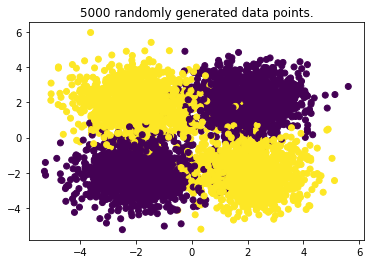

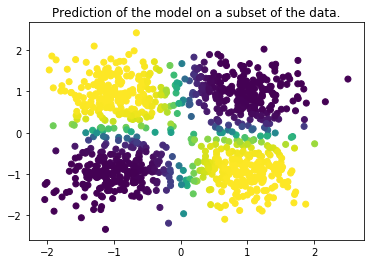

In [88]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})
np.random.seed(1)

nb_samples = 5000
samples = np.ones((nb_samples, 3))
distance = 2

input_size = 2

for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i, :] = [-distance+noise[0],-distance+noise[1], 0]
    samples[i+1, :] = [distance+noise[2],-distance+noise[3], 1]
    samples[i+2, :] = [-distance+noise[4],distance+noise[5], 1]
    samples[i+3, :] = [distance+noise[6],distance+noise[7], 0]

fig1=plt.figure()
plt.title("{0} randomly generated data points.".format(nb_samples))
plt.scatter([element[0] for element in samples],
            [element[1] for element in samples],
            c=[element[2] for element in samples])

scaler = preprocessing.StandardScaler().fit(samples[:int(len(samples)*0.6),:input_size])
samples[:,:input_size] = scaler.transform(samples[:,:input_size])

input_pipe = InputPipeLine(samples, input_size=input_size, batch_size=20)

layers = [Layer(Linear(), size=input_size),
          Layer(Relu(), size=10),
          Layer(Sigmoid(), size=1)]

mlp_object = Dnn(layers=layers, 
                 input_pipe=input_pipe,
                 scaler = lambda x: x,
                 error=Mse())

mlp_object.train(epochs=100, 
                 optimizer=Sgd(lrate=0.01))

results = mlp_object.test(verbose=0.01)

fig2=plt.figure()
plt.title("Prediction of the model on a subset of the data.")
plt.scatter([element[0][0] for element in results],
            [element[0][1] for element in results],
            c=[element[2][0] for element in results])
     

#### Boston house-prices

In [81]:
boston = datasets.load_boston()

features = len(boston['data'][0])
nb_samples = len(boston['data'])

samples = np.ones((nb_samples, features+1))

samples[:,:features] = boston['data'][:,:]
samples[:,-1] = boston['target'][:]

scaler = preprocessing.StandardScaler().fit(samples[:int(0.6*len(samples))])

data = scaler.transform(samples)

bostondata = pd.DataFrame(samples,columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MED'])


scaled_bostondata = pd.DataFrame(data,columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MED'])

disp.display(bostondata.head())
disp.display(scaled_bostondata.head().round({'CRIM':4,'ZN':2,'INDUS':2,'CHAS':1,'NOX':2,'RM':3,'AGE':1,'DIS':3,'RAD':1,'TAX':2,'PTRATIO':2,'B':4,'LSTAT':2,'MED':2}))

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MED
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MED
0,-0.6377,0.09,-1.03,-0.3,0.23,0.217,0.1,-0.105,-2.2,-0.24,-1.0,0.4199,-0.92,-0.17
1,-0.6062,-0.60,-0.28,-0.3,-0.41,-0.002,0.6,0.338,-1.5,-1.02,0.1,0.4199,-0.25,-0.44
2,-0.6063,-0.60,-0.28,-0.3,-0.41,1.086,-0.0,0.338,-1.5,-1.02,0.1,0.3253,-1.08,1.04
3,-0.5986,-0.60,-1.05,-0.3,-0.51,0.820,-0.6,0.891,-0.9,-1.31,0.5,0.3671,-1.25,0.90
4,-0.5437,-0.60,-1.05,-0.3,-0.51,1.032,-0.3,0.891,-0.9,-1.31,0.5,0.4199,-0.87,1.21


In [83]:
np.random.seed(1)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

input_pipe = InputPipeLine(data, input_size=13, batch_size=50)

mlp_object = Dnn(
    [Layer(Linear(), size=13),
     Layer(Sigmoid(), size=20),
     Layer(Relu(), size=20),
     Layer(Linear(), size=1)],
    input_pipe,
    scaler=lambda x: x*scaler.scale_[-1]+scaler.mean_[-1],
    error=Mse())

mlp_object.train(epochs=900, 
                 optimizer=Adam(lrate=0.001), 
                 weight_log=False)

results = mlp_object.test(verbose=0.1)

TRAINING PHASE:

>>> Optimizer:	ADAM
>>> Error:	Mean Squared Error
>>> Layers:	4
>>> Batch size:	50

>>> Epoch: 0	 Train error: 147.490	 Validation error: 197.991
>>> Epoch: 20	 Train error: 41.691	 Validation error: 172.882
>>> Epoch: 40	 Train error: 22.359	 Validation error: 135.492
>>> Epoch: 60	 Train error: 14.722	 Validation error: 119.266
>>> Epoch: 80	 Train error: 11.255	 Validation error: 118.270
>>> Epoch: 100	 Train error: 8.853	 Validation error: 122.758
>>> Epoch: 120	 Train error: 7.356	 Validation error: 130.861
>>> Epoch: 140	 Train error: 6.389	 Validation error: 142.660
>>> Epoch: 160	 Train error: 5.631	 Validation error: 150.693
>>> Epoch: 180	 Train error: 5.093	 Validation error: 157.722
>>> Epoch: 200	 Train error: 4.657	 Validation error: 161.920
>>> Epoch: 220	 Train error: 4.281	 Validation error: 168.273
>>> Epoch: 240	 Train error: 3.973	 Validation error: 174.614
>>> Epoch: 260	 Train error: 3.705	 Validation error: 181.516
>>> Epoch: 280	 Train error: 3.

#### MNIST

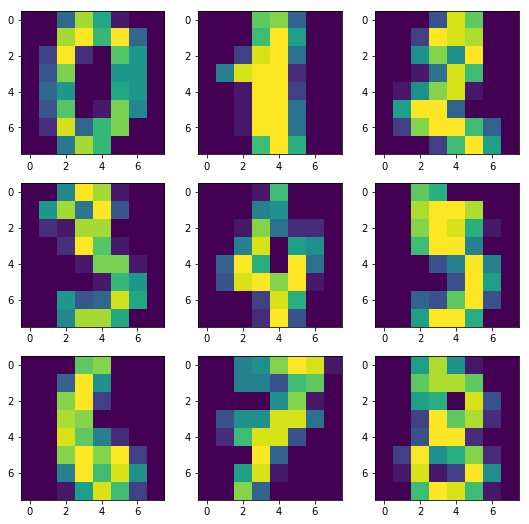

In [139]:
digits = datasets.load_digits()

figure = plt.figure(figsize=(9, 9))
for index in range(9):
    figure.add_subplot(3,3,index+1)
    plt.imshow(digits['images'][index])

In [140]:
def toOneHot(x):
    onehot = np.zeros((1,10))
    onehot[0][x] = 1
    return onehot

In [141]:
np.random.seed(1)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

samples = np.ones((digits['data'].shape[0], digits['data'].shape[1]+10))
samples[:,:-10] = digits['data']
for index in range(digits['data'].shape[0]):
    samples[index,-10:] = toOneHot(digits['target'][index])[:]
    
# scaler = preprocessing.StandardScaler().fit(samples[:int(len(samples*0.6)),:-10])
# samples[:,:-10] = scaler.transform(samples[:,:-10])

# TODO: overflow if batch size is lower than 20 -> investigate
input_pipe = InputPipeLine(samples, input_size=64, batch_size=20)

layers = [Layer(Linear(), size=64),
          Dropout(Layer(Tanh(), size=100), probability=0.5),
          Dropout(Layer(Relu(), size=100), probability=0.5),
          Dropout(Layer(Relu(), size=20), probability=0.5),
          Layer(Softmax(), size=10)]

mlp_object = Dnn(layers,
                 input_pipe,
                 scaler=lambda x: x,
                 error=CrossEntropy())

mlp_object.train(epochs=100, optimizer=Adam(lrate=0.01))

results = mlp_object.test(verbose=0.05)

TRAINING PHASE:

>>> Optimizer:	ADAM
>>> Error:	Categorical Cross Entropy
>>> Layers:	5
>>> Batch size:	20

>>> Epoch: 0	 Train error: 0.265	 Validation error: 0.142
>>> Epoch: 20	 Train error: 0.048	 Validation error: 0.149
>>> Epoch: 40	 Train error: 0.023	 Validation error: 0.104
>>> Epoch: 60	 Train error: 0.017	 Validation error: 0.141
>>> Epoch: 80	 Train error: 0.012	 Validation error: 0.171
>>> Epoch: 100	 Train error: 0.009	 Validation error: 0.140

WEIGHT STATISTICS:



Weight Layer 1                     Weight Layer 2                      \
              avg       max       min            avg       max       min   
0        0.000288  0.333251 -0.333269      -0.000024  0.299852 -0.299972   
1       -0.001329  0.531215 -0.511753      -0.000520  0.471290 -0.478230   
2        0.000072  0.825991 -0.917711      -0.000915  0.839826 -0.769725   
3        0.001458  1.208146 -1.330073       0.000672  0.881363 -0.931181   
4        0.005361  1.469892 -1.576212      -0.000009  1.099962 -1.127164   
5       -0.007166  1.621556 -1.722267      -0.000322  1.143155 -1.163434   
6       -0.011474  1.713081 -1.872174       0.001661  1.257644 -1.354409   
7       -0.007030  1.832992 -2.007586       0.001126  1.177110 -1.430265   
8       -0.011785  2.110338 -2.256257       0.000870  1.284941 -1.749603   
9       -0.001844  2.129137 -2.241654       0.001942  1.570843 -1.716960   
10      -0.005796  2.272671 -2.569960       0.003993  1.575671 -1.775956   
11      -0.017351  2.431327 -2.754985       0.005107  1.562580 -1.762274   

   Weight Layer 3                     Weight Layer 4                      
              avg       max       min            avg       max       min  
0        0.006117  0.414452 -0.414433       0.059264  0.772025 -0.784146  
1       -0.011017  0.518635 -0.533108       0.052104  0.863356 -0.842804  
2       -0.021057  0.844525 -0.683542       0.051050  0.987196 -0.947554  
3       -0.029713  0.930124 -0.970922       0.054834  0.799591 -0.841476  
4       -0.036980  1.021596 -0.938774       0.051907  0.830708 -0.891158  
5       -0.038270  1.050244 -1.076583       0.054526  0.801077 -0.891286  
6       -0.055874  1.082609 -1.208289       0.056358  0.815079 -0.891293  
7       -0.057409  1.415038 -1.113691       0.060464  0.858646 -1.010986  
8       -0.074602  1.185418 -1.123863       0.068633  0.841397 -0.891293  
9       -0.078441  1.266328 -1.103507       0.062983  0.871984 -0.891293  
10      -0.079541  1.286406 -1.133731       0.067902  0.953325 -0.926651  
11      -0.078803  1.357847 -1.195446       0.066274  0.957921 -1.071039


TESTING PHASE:
(displaying 5.0% of the test data)

>>> Test error: 0.22013201313032246

>>> Expected: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]  Prediction: [0.000 0.000 0.000 0.000 0.754 0.000 0.000 0.242 0.000 0.003]	
>>> Expected: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]  Prediction: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]	
>>> Expected: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]  Prediction: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]	
>>> Expected: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]  Prediction: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]	
>>> Expected: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000]  Prediction: [0.000 0.034 0.060 0.328 0.000 0.000 0.001 0.001 0.577 0.001]	
>>> Expected: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]  Prediction: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]	


TESTING PHASE:
(displaying 100% of the test data)

>>> Test error: 1.0217164129950881e-05

>>> Expected: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000]  Prediction: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000]	

TESTING PHASE:
(displaying 100% of the test data)

>>> Test error: 0.0024205917676878718

>>> Expected: [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000]  Prediction: [0.000 0.000 0.000 0.000 0.000 0.983 0.017 0.000 0.000 0.000]	

TESTING PHASE:
(displaying 100% of the test data)

>>> Test error: 0.0

>>> Expected: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]  Prediction: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]	


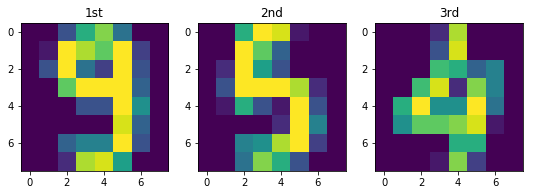

In [142]:
fig = plt.figure(figsize=(9, 9))
fig.add_subplot(1,3,1)
plt.title("1st")
mlp_object.test(x=np.array([digits['data'][-5]]), target=(toOneHot(digits['target'][-5])), custom_data=True)
plt.imshow(digits['images'][-5])
fig.add_subplot(1,3,2)
plt.title("2nd")
mlp_object.test(x=np.array([digits['data'][-10]]), target=(toOneHot(digits['target'][-10])), custom_data=True)
plt.imshow(digits['images'][-10])
fig.add_subplot(1,3,3)
plt.title("3rd")
mlp_object.test(x=np.array([digits['data'][-20]]), target=(toOneHot(digits['target'][-20])), custom_data=True)
plt.imshow(digits['images'][-20])